# **Trabajo Práctico Nº2**

Amalia Oxandaberro - Mariana Szewach - Camila Cirignoli

En el siguiente trabajo se utiliza el archivo rossman.ipyn como modelo de trabajo.

#Librerías

En primer lugar, se cargan todas las librerias a utilizar en el siguiente trabajo

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from string import punctuation
from termcolor import colored
from collections import Counter
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import datetime
#from isoweek import Week
!pip install isoweek
from isoweek import Week

import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import matplotlib.pyplot as plt, operator, random, pickle
!pip install utils2
from utils2 import *
!pip install pandas_summary
from pandas_summary import DataFrameSummary
from IPython.display import SVG
from numpy import mean, sqrt, square, arange

  Created wheel for utils2: filename=utils2-0.1.2-py2.py3-none-any.whl size=5240 sha256=c2133f3ebbe29ea9600efd7cc2ce1bdb169df625b640b9d509c67cece6ddaaf3
  Stored in directory: /root/.cache/pip/wheels/4a/e7/dd/07ae855e161aa42be8bdd0144343780e418b3563b0c7d742fb
Successfully built utils2


#Datos de Kaggle

Luego se prosigue cargando los datos desde kaggle

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amaliaoxandaberro","key":"dc3caded742346409c8426f0109c18a1"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c rossmann-store-sales

  0% 0.00/192k [00:00<?, ?B/s]
100% 192k/192k [00:00<00:00, 6.37MB/s]
 75% 5.00M/6.71M [00:00<00:00, 37.0MB/s]
100% 6.71M/6.71M [00:00<00:00, 42.8MB/s]
  0% 0.00/310k [00:00<?, ?B/s]
100% 310k/310k [00:00<00:00, 102MB/s]
  0% 0.00/44.0k [00:00<?, ?B/s]
100% 44.0k/44.0k [00:00<00:00, 46.1MB/s]


In [4]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


Además de los datos de la competencia, se buscaron datasets que aportaran información complementaria, siendo estos:

* googletrend: datos de las tendencias para cada semana y estado obtenidas con la herramienta de google
* state_names: tabla conteniendo los nombres de los estados junto con sus abreviaciones
* store_states: datos de los nombres de los estados en los que se encuentra cada store
* weather: datos del clima para cada estado

Previo a correr esta celda, se deben cargar los archivos adjuntos en el github al entorno de ejecución utilizado. Estos son: 

* googletrend.csv 
* state_names.csv
* store_states.csv
* weather.csv


In [268]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
store = pd.read_csv("/content/store.csv")

googletrend = pd.read_csv("/content/googletrend.csv")
state_names = pd.read_csv("/content/state_names.csv")
store_states = pd.read_csv("/content/store_states.csv")
weather = pd.read_csv("/content/weather.csv")


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Los campos provistos por la competencia son los siguientes:

**Customers**: número de clientes en un cierto día

**Open**: indicador de si la tienda se encontraba abierta: 0 = cerrada, 1= abierta

**StateHoliday**: indica un feriado nacional. Normalmente las tiendas se encuentran cerradas en un feriado nacional. a = feriado público, b= feriado por pascuas, c= feriado por navidad, 0 = Ninguno

**School Holiday**: indica si hay feriado escolar, brindando información de si la tienda fue afectada por el cierre de escuelas públicas.

**StoreType:** distingue entre 4 modelos diferentes: a, b, c,d.

**Assortment:** describe un nivel de variedad de los productos que se venden en determinada tienda: a = basico, b = extra, c = extended

**CompetitionDistance:** distancia medida en metros de la tienda competidora más cercana.

**CompetitionOpenSince[Month/Year]:** indica el mes y año aproximado en el que la tienda competidora más cercana abrió.

**Promo:** indica si la tienda brinda una promoción en esa fecha.

**Promo2:** refiere a un tipo de promoción continua y consecutiva para ciertas tiendas: 0= tienda no participa, 1= tienda participa.

**Promo2Since[Year/Week]:** describe la semana y año en los que la tienda comenzó participando en la Promo2.

**PromoInterval:** describe los meses en los que comenzó la Promo2. 


A continuación se examinan las tablas cargadas y su contenido

In [270]:
display(train.head())
display(DataFrameSummary(train).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,5,2


In [271]:
display(store.head())
display(DataFrameSummary(store).summary())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


In [272]:
display(store_states.head())
display(DataFrameSummary(store_states).summary())

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


In [273]:
display(state_names.head())
display(DataFrameSummary(state_names).summary())

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,StateName,State
count,16,16
unique,16,16
top,SachsenAnhalt,SL
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


In [274]:
display(googletrend.head())
display(DataFrameSummary(googletrend).summary())

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


In [275]:
display(weather.head())
display(DataFrameSummary(weather).summary())

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,50.1586,1018.53,1015.3,1012.31,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,19.9602,7.78872,8.12331,8.60058,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,4,976,974,970,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,34,1014,1010,1007,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,49,1019,1016,1013,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,66,1024,1021,1018,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,100,1043,1040,1038,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,93,67,67,69,24,32,24,44,29,47,41,9,21,362


#Data cleaning and feature engineering 


Data cleaning es el proceso de transformación de los datos en un formato el cual el modelo pueda entender. Además se eliminan datos irrelevantes, se cambia el formato de datos o se rellenan los datos faltantes. 

Feature engineering es el proceso de utilización de los datos para crear nuevos campos que aporten información relevante al modelo. De esta manerá será más facil que el modelo aprenda. Por ejemplo, en esta competencia se crea un campo llamado **CompetitionOpenSince** y otro llamado **CompetitionDaysOpen** utilizando otros campos provistos

En primer lugar se pasa el campo **StateHoliday** a boolean


In [276]:
train.StateHoliday 
#vemos que son 0, a, b y c entonces lo pasamos a boolean

0          0
1          0
2          0
3          0
4          0
          ..
1017204    a
1017205    a
1017206    a
1017207    a
1017208    a
Name: StateHoliday, Length: 1017209, dtype: object

In [277]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday != '0'

Se crea una función para unir tablas. Luego con esta función se unen las tablas de **weather** y **state_names**

In [278]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))
weather = join_df(weather, state_names, "file", "StateName")
weather

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225,NordrheinWestfalen,NW
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240,NordrheinWestfalen,NW
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263,NordrheinWestfalen,NW
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268,NordrheinWestfalen,NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15835,Saarland,2015-09-13,21,17,12,16,14,12,100,88,68,1015,1010,1005,31.0,15.0,10.0,27,10,50.0,1.02,7.0,Rain,113,Saarland,SL
15836,Saarland,2015-09-14,18,14,11,15,12,7,99,85,61,1009,1005,1004,31.0,13.0,4.0,32,16,53.0,9.91,5.0,Rain-Thunderstorm,213,Saarland,SL
15837,Saarland,2015-09-15,16,12,9,11,8,7,93,77,62,1010,1008,1004,31.0,12.0,10.0,34,14,NaN,0.00,5.0,Rain,193,Saarland,SL
15838,Saarland,2015-09-16,19,15,11,16,13,10,97,90,75,1004,999,995,31.0,10.0,4.0,32,14,45.0,20.07,7.0,Rain-Thunderstorm,147,Saarland,SL


Se crean los datos **Date** y **State** en la tabla de googletrend. 

Como se observa más adelante en googletrend uno de los estados está escrito distinto (NI en vez de HB,NI) por lo que se pasa a una forma de escritura.



In [279]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

In [280]:
bla = store_states['State'] == 'HB,NI'
store_states[bla]

,Store,State
9,10,"HB,NI"
69,70,"HB,NI"
106,107,"HB,NI"
111,112,"HB,NI"
267,268,"HB,NI"
303,304,"HB,NI"
378,379,"HB,NI"
503,504,"HB,NI"
510,511,"HB,NI"
561,562,"HB,NI"


In [281]:
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

En cada tabla con el campo datetime, se pasa este dato a 4 datos que representan lo mismo.
 
Se pasa de datetime a año, mes, semana y día. Si bien la información de estos campos es equivalente a la información del campo datetime, separar la información ayuda a detectar comportamiento cíclico/tendencias. 

In [282]:
def add_datepart(df):
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.week
    df["Day"] = df.Date.dt.day
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [283]:
add_datepart(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


Se crea un dataset aparte extrayendo de googletrend la información de Alemania sin ser separada por estado.

In [284]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']   #esto es el trend de toda alemania, el resto es por estado

Se unifican todas las tablas para obtener un data frame único

In [285]:
store = join_df(store, store_states, "Store")  #junta las tablas store y store_states
len(store[store.State.isnull()]) #despues chequea si quedo alguna con null, para ver si quedo bien hecho el join

0

In [286]:
joined = join_df(train, store, "Store")  #junta las anteriores mas la de train
len(joined[joined.StoreType.isnull()])

0

In [287]:
joinedT = join_df(test, store, "Store")  #junta las anteriores mas la de test
len(joinedT[joinedT.StoreType.isnull()])

0

En este paso se agregan los datos de googletrend. Sin embargo ya que una de las columnas de unión es state, no se unirán los datos que contiene trend_de, por lo que se realiza un merge con esta tabla en los próximos pasos.


In [288]:
joined = join_df(joined, googletrend, ["State","Year", "Week"]) #junta las anteriores mas la de googletrend
len(joined[joined.trend.isnull()])

0

In [289]:
joinedT = join_df(joinedT, googletrend, ["State","Year", "Week"]) #junta las anteriores mas la de googletrend, para test
len(joinedT[joinedT.trend.isnull()])

0

Como se mencionó anteriormente, cuando se seleccionan aquellos datos en que el file es Rossman_DE, en el estado se va a tener algo que nunca aparece para cada uno de los sufijos con estado (NaN, 0). 

Cuando se realiza el merge y dado que se une por estado, aquellos que tengan Nan o 0 no van quedar. 


In [290]:
joined['file'].value_counts()

Rossmann_DE_NW    269412
Rossmann_DE_BY    136440
Rossmann_DE_SH    108329
Rossmann_DE_HE    105504
Rossmann_DE_BE     86664
Rossmann_DE_SN     70650
Rossmann_DE_BW     68766
Rossmann_DE_ST     52752
Rossmann_DE_RP     37680
Rossmann_DE_TH     33912
Rossmann_DE_HH     26376
Rossmann_DE_NI     20724
Name: file, dtype: int64

In [291]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
print(len(joined[joined.trend_DE.isnull()]))
joinedT = joinedT.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
print(len(joinedT[joinedT.trend_DE.isnull()]))

0
0


In [292]:
joined = join_df(joined, weather, ["State","Date"]) #junta las anteriores mas la de weather
print(len(joined[joined.Mean_TemperatureC.isnull()]))
joinedT = join_df(joinedT, weather, ["State","Date"]) #junta las anteriores mas la de weather
print(len(joinedT[joinedT.Mean_TemperatureC.isnull()]))

0
0


A continuación se rellenan los valores que se encuentren vacios para evitar problemas con NaNs. Dependiendo de la variable se rellenan con distintos valores por default. 

La funcion fillna reemplaza todos los valores de NaN con el año 1990 (toma como que los competidores estan desde esta fecha) y el mes 1.

In [293]:
joined.CompetitionOpenSinceYear = joined.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joined.CompetitionOpenSinceMonth = joined.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joined.Promo2SinceYear = joined.Promo2SinceYear.fillna(1900).astype(np.int32)
joined.Promo2SinceWeek = joined.Promo2SinceWeek.fillna(1).astype(np.int32)

joinedT.CompetitionOpenSinceYear = joinedT.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joinedT.CompetitionOpenSinceMonth = joinedT.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joinedT.Promo2SinceYear = joinedT.Promo2SinceYear.fillna(1900).astype(np.int32)
joinedT.Promo2SinceWeek = joinedT.Promo2SinceWeek.fillna(1).astype(np.int32)

Al igual que con el campo datetime, se utilizan los datos de las columnas **CompetitionOpenSinceYear** y **CompetitionOpenSinceMonth** para crear los campos de **CompetitionOpenSince**  y **CompetitionDaysOpen**, los cuales brindan información adicional.



In [295]:
joined["CompetitionOpenSince"] = pd.to_datetime(dict(year=joined.CompetitionOpenSinceYear, month=joined.CompetitionOpenSinceMonth,
day=15))
joined["CompetitionDaysOpen"] = joined.Date.subtract(joined["CompetitionOpenSince"]).dt.days

joinedT["CompetitionOpenSince"] = pd.to_datetime(dict(year=joinedT.CompetitionOpenSinceYear, month=joinedT.CompetitionOpenSinceMonth,
day=15))
joinedT["CompetitionDaysOpen"] = joinedT.Date.subtract(joinedT["CompetitionOpenSince"]).dt.days

Se reemplazan datos incorrectos e inválidos, por ejemplo las instancias en las que **CompetitionDaysOpen** es menor a cero.
 
Al no haber información, para todas las filas que tienen **CompetitionOpenSinceYear** <1990, el **CompetitionDaysOpen** se pone en 0. Esto se realiza debido a la poca consistencia de los datos de **CompetitionDaysOpen** para las tiendas que tienen competidores que figuran que abrieron antes de 1990.

In [297]:
joined.loc[joined.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined.loc[joined.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

joinedT.loc[joinedT.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joinedT.loc[joinedT.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Se limita el campo **CompetitionMonthsOpen** a 2 años, es decir, a 24 meses para restringir las dimensiones de los vectores de embedding. 


In [298]:
joined["CompetitionMonthsOpen"] = joined["CompetitionDaysOpen"]//30
joined.loc[joined.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

joinedT["CompetitionMonthsOpen"] = joinedT["CompetitionDaysOpen"]//30
joinedT.loc[joinedT.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joinedT.CompetitionMonthsOpen.unique()

array([24, 11,  0, 18, 19, 17, 21, 13,  9,  2, 14,  4,  6, 12,  3, 16, 10,
       15, 20, 22,  5, 23,  7,  1,  8])

Se repite lo anterior para las fechas de **Promo2**

In [300]:
joined["Promo2Since"] = pd.to_datetime(joined.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
joined["Promo2Days"] = joined.Date.subtract(joined["Promo2Since"]).dt.days

joinedT["Promo2Since"] = pd.to_datetime(joinedT.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
joinedT["Promo2Days"] = joinedT.Date.subtract(joinedT["Promo2Since"]).dt.days

In [302]:
joined.loc[joined.Promo2Days<0, "Promo2Days"] = 0
joined.loc[joined.Promo2SinceYear<1990, "Promo2Days"] = 0

joinedT.loc[joinedT.Promo2Days<0, "Promo2Days"] = 0
joinedT.loc[joinedT.Promo2SinceYear<1990, "Promo2Days"] = 0

In [303]:
joined["Promo2Weeks"] = joined["Promo2Days"]//7
joined.loc[joined.Promo2Weeks<0, "Promo2Weeks"] = 0
joined.loc[joined.Promo2Weeks>25, "Promo2Weeks"] = 25
joined.Promo2Weeks.unique()

joinedT["Promo2Weeks"] = joinedT["Promo2Days"]//7
joinedT.loc[joinedT.Promo2Weeks<0, "Promo2Weeks"] = 0
joinedT.loc[joinedT.Promo2Weeks>25, "Promo2Weeks"] = 25
joinedT.Promo2Weeks.unique()

array([ 0, 25, 24, 15, 20, 23, 14, 19, 22, 13, 18, 21, 12, 17, 11, 16, 10,
        9,  8])

#Duraciones

Cuando se trabaja con datos relacionados a series de tiempo es útil extraer información que explique las relaciones entre filas en vez de columnas como se hace generalmente. Por ejemplo:  

*   Media móvil
*   Tiempo hasta el próximo evento
*   Tiempo desde el último evento

Para facilitar estos análisis se crea una clase que permite manipular este tipo de datos.

In [304]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

La clase "elapsed" se utiliza para hacer un conteo acumulativo. Dado un campo en particular que se desee monitorear, este objeto comenzará a contar el tiempo transcurrido desde la última ocurrencia de dicho campo. Cuando ocurre nuevamente, el contador vuelve a comenzar. 

Cuando se inicializa, el contador mostrará NaN como resultado hasta que encuentre una ocurrencia del campo. Se resetea cada vez que cambia de store. 


In [305]:
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date
        return row.Date-self.last

In [306]:
df = train[columns]
df_test = test[columns]

Se crea una función para aplicar dicha clase en el dataframe agregando los valores a nuevas columnas.

In [307]:
def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)
    df_test[prefix+fld] = df_test.apply(sh_el.get, axis=1)

Por ejemplo, al tratar con el campo **School Holiday**, primero se ordena por **Store** despues por **Date** y se utiliza la función add_elapsed('SchoolHoliday', 'After'). 

Esto genera una instancia de la clase elapsed para el campo **SchoolHoliday**. Se aplica a cada fila del dataframe ordenado por **Store** y **Date**. Se agrega al dataframe la cantidad de días que pasaron desde el último **SchoolHoliday**. Si en lugar de 'After' se utiliza 'Before' se contarán los días que faltan para el próximo **SchoolHoliday**. 

In [308]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')

df = df.sort_values(['Store', 'Date'], ascending=[True, False])
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

Se repite lo mismo para **StateHoliday** y **Promo**.

In [309]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')

df = df.sort_values(['Store', 'Date'], ascending=[True, False])
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [310]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')

df = df.sort_values(['Store', 'Date'], ascending=[True, False])
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

Se setea la fecha (campo **Date**) como índice para poder implementar funciones como la media móvil. 

In [311]:
df = df.set_index("Date")
df_test = df_test.set_index("Date")

Se cambian los valores de NaN a 0 en los campos calculados con la clase elapsed. 

In [313]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [314]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(pd.Timedelta(0)).dt.days
        df_test[a] = df_test[a].fillna(pd.Timedelta(0)).dt.days

Se ordena según **Date** y se agrupa según **Store**. 

Se reemplazan los valores de la columna **SchoolHoliday** (contenía ceros o unos según si era o no un feriado escolar) para demostrar cuantos días pasaron desde el último feriado escolar. 

Luego se realiza lo mismo en el sentido contrario (mostrar cuantos días faltan para el próximo feriado) y para el resto de los campos trabajados. 

In [315]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd.head(15)
bwd_test = df_test[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [316]:
fwd = df[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
fwd.head(15) 

fwd_test = df_test[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()


Se eliminan los índices utilizados para agrupar por **Store**.

In [317]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)
bwd.head(15)

bwd_test.drop('Store',1,inplace=True)
bwd_test.reset_index(inplace=True)
#bwd_test.head(15)

In [318]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

fwd_test.drop('Store',1,inplace=True)
fwd_test.reset_index(inplace=True)

In [319]:
df.reset_index(inplace=True)
df_test.reset_index(inplace=True)

Se unen los valores obtenidos a la tabla df que contenia los datos para train.

In [320]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

df_test = df_test.merge(bwd_test, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd_test, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [321]:
df.drop(columns,1,inplace=True)
df_test.drop(columns,1,inplace=True)

Se guarda un backup de la tabla df en un archivo.csv

In [323]:
df.to_csv('df.csv')
df_test.to_csv('df_test.csv')

In [324]:
df = pd.read_csv('df.csv', index_col=0)
df_test = pd.read_csv('df_test.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [325]:
df["Date"] = pd.to_datetime(df.Date)
df_test["Date"] = pd.to_datetime(df_test.Date)

A continuación se muestran los campos que quedan en la tabla df

In [327]:
print(df.columns)
print(df_test.columns)

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')
Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')


Se unen las tablas joined (la que se armó inicialmente uniendo todas las tablas de datos disponibles) y df (la tabla que contiene duraciones de las series de tiempo).

Se realiza un backup nuevamente, en este caso de la tabla joined

In [328]:
joined = join_df(joined, df, ['Store', 'Date'])
joinedT = join_df(joinedT, df_test, ['Store', 'Date'])

In [ ]:
joined.to_csv('joined.csv')
joinedT.to_csv('joinedT.csv')

Con esto se obtiene el set final de características. 

In [330]:
joined = pd.read_csv('joined.csv', index_col=0)
joined["Date"] = pd.to_datetime(joined.Date)
print(joined.columns)

joinedT = pd.read_csv('joinedT.csv', index_col=0)
joinedT["Date"] = pd.to_datetime(joinedT.Date)
print(joinedT.columns)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE',
       'trend_DE', 'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees',
       

#Create features
Una vez realizado el feature engineering, se tiene que convertir el input a un formato compatible para la red neuronal. Esto implica convertir las variables categóricas en distintos integers o one-hot vectors y normalizar las variables contínuas restando la media y dividiendo por el desvío estándar.



In [332]:
from sklearn_pandas import DataFrameMapper
#!pip install sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler


Se define un diccionario que mapea las distintas categorías con la dimensión de su vector de embedding. Generalmente las categorías más complejas tienen dimensiones más grandes.

In [333]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

cat_var_dict_test = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [334]:
cat_vars = [o[0] for o in sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]
cat_vars_test = [o[0] for o in sorted(cat_var_dict_test.items(), key=operator.itemgetter(1), reverse=True)]

Se realiza el mismo procedimiento para las variables continuas.

In [335]:
# mean/max wind; min temp; cloud; min/mean humid; 
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

contin_vars_test = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Se reemplazan los valores nulos con 0 para las variables continuas y ' ' para las categoricas. 

In [336]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

for v in contin_vars_test: joinedT.loc[joinedT[v].isnull(), v] = 0
for v in cat_vars_test: joinedT.loc[joinedT[v].isnull(), v] = ""

Se crea una lista de tuplas que contiene una variable y la transformación de pre-pocesamiento que se le va a aplicar a cada variable.

Para las variables categóricas se le aplicará un LaberEncoder() que mapea las categorías a enteros consecutivos (si son 5 clases mapeará a 0,1,2,3,4). A las variables continuas se les aplicará un StandardScaler que las normaliza (resta la media y divide por el desvío standard).



In [337]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

cat_maps_test = [(o, LabelEncoder()) for o in cat_vars_test]
contin_maps_test = [([o], StandardScaler()) for o in contin_vars_test]

Se crea un DataFrameMapper que recibe las tuplas con nombre de columna y la transformación de preprocesamiento que se debe aplicar y se fitea para generar el modelo. Esto se aplicará por separado para las variables categóricas y continuas.

Se debe realizar el mismo procedimiento para el set de datos de test.

In [338]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
print(cat_cols)

cat_mapper_test = DataFrameMapper(cat_maps_test)
cat_map_fit_test = cat_mapper_test.fit(joinedT)
cat_cols_test = len(cat_map_fit_test.features)
print(cat_cols_test)

22
22


In [339]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
print(contin_cols)

contin_mapper_test = DataFrameMapper(contin_maps_test)
contin_map_fit_test = contin_mapper_test.fit(joinedT)
contin_cols_test = len(contin_map_fit_test.features)
print(contin_cols_test)

16
16


Se observa un ejemplo de cómo quedan los vectores de una variable de cada tipo:

In [340]:
cat_map_fit.transform(joined)[0,:5]

cat_map_fit_test.transform(joinedT)[0,:5]

array([ 0, 16,  3,  1,  3])

In [341]:
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

pickle.dump(contin_map_fit_test, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit_test, open('cat_maps.pickle', 'wb'))

In [342]:
print([len(o[1].classes_) for o in cat_map_fit.features])
print([len(o[1].classes_) for o in cat_map_fit_test.features])

[1115, 31, 7, 12, 12, 23, 8, 22, 2, 3, 4, 3, 25, 4, 52, 26, 6, 6, 8, 8, 8, 8]
[856, 31, 7, 2, 8, 23, 8, 8, 2, 3, 4, 1, 25, 4, 8, 19, 6, 6, 2, 2, 8, 8]


#Sample data
Se eliminan los casos en los que la tienda estaba cerrada o no tuvo ventas. 

In [343]:
joined_sales = joined[joined.Sales!=0]
n = len(joined_sales)

Usualmente, antes y despues de un periodo de tiempo en el que la tienda esté cerrada, se da un aumento en las ventas, para prepararse para dicho periodo de cierre o para compensar la falta de los productos durante dicho periodo.

Debido a esto, eliminar los datos que corresponden a un cierre de la tienda puede perjudicar la performance del modelo al momento de predecir el comportamiento en momentos cercanos a un cierre. 

In [344]:
n

844338

Se prueba con una muestra. 

In [345]:
samp_size = 100000
np.random.seed(42)
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [ ]:
joined_samp = joined_sales.iloc[idxs].set_index("Date")

In [ ]:
samp_size = n   #pasa de hacer una prueba con una muestra a tomar todos los datos
joined_samp = joined_sales.set_index("Date")

Para modelos con series de tiempo, se selecciona el set de validación de acuerdo a la fecha de los datos. Se eligen los datos más recientes simulando lo que pasaría en la vida real.

En este caso se toma el 10% del set de train para validar. 

In [348]:
train_ratio = 0.9
train_size = int(samp_size * train_ratio)

In [349]:
train_size

759904

In [350]:
joined_valid = joined_samp[train_size:]
joined_train = joined_samp[:train_size]
len(joined_valid), len(joined_train)

(84434, 759904)

Con esta función se preprocesan las variables categóricas.

In [351]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

In [352]:
def cat_preproc_test(dat):
    return cat_map_fit_test.transform(dat).astype(np.int64)

In [353]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)
cat_map_test = cat_preproc_test(joinedT)

Se hace lo mismo para las variables continuas. 


In [354]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)
def contin_preproc_test(dat):
    return contin_map_fit_test.transform(dat).astype(np.float32)

In [355]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)
contin_map_test = contin_preproc_test(joinedT)

Se toman las labels.


In [356]:
y_train_orig = joined_train.Sales
y_valid_orig = joined_valid.Sales

Finalmente se aplica una transformación logaritmica a las labels y se las normaliza. Este tipo de transformaciones se suele hacer para este tipo de datos para obtener dimensiones mas manejables. 

Además al normalizar todos los valores quedarán entre 0 y 1 por lo que se puede utilizar una función de activación sigmoidea como la salida de la red. Luego podemos volver a multiplicar por el valor logarítmico maximo para obtener el valor original y volver a transformar. 

In [357]:
max_log_y = np.max(np.log(joined_samp.Sales))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y

#Create models
A continuación se crea el modelo. 

In [358]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [359]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

La siguiente función devuelve el nombre de la categoría y la dimensión. 

In [360]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

Se muestra un ejemplo de la función anterior:

In [361]:
cat_map_info(cat_map_fit.features[1])

('Day', 31)

In [362]:
def my_init(scale):
    return lambda shape, name=None: initializations.uniform(shape, scale=scale, name=name)

In [363]:
def emb_init(shape, name=None): 
    return initializations.uniform()
#shape, scale=2/(shape[1]+1), name=name    

La siguiente función genera los embeddings.

Además de construir los vectores de embeddings, se genera el flattening.

In [364]:
def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    return inp,u

La siguiente función se aplica para inputs continuos.

In [365]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', init=my_init(1.))(inp)

In [366]:
from keras.layers import Input, Dense, Flatten, Embedding, merge, Dropout
from keras import initializers as initializations
from keras.models import Model

In [367]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)

Se define la función de root_mean_squared_error la cual evaluará la performance final del modelo

In [368]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

En la siguiente celda se mapea cada campo de variable categórica con su correspondiente preprocesado.

In [369]:
cat_map_fit.features

[('Store', LabelEncoder()),
 ('Day', LabelEncoder()),
 ('DayOfWeek', LabelEncoder()),
 ('Month', LabelEncoder()),
 ('State', LabelEncoder()),
 ('CompetitionOpenSinceYear', LabelEncoder()),
 ('Promo2SinceYear', LabelEncoder()),
 ('Events', LabelEncoder()),
 ('StateHoliday', LabelEncoder()),
 ('Assortment', LabelEncoder()),
 ('PromoInterval', LabelEncoder()),
 ('Year', LabelEncoder()),
 ('CompetitionMonthsOpen', LabelEncoder()),
 ('StoreType', LabelEncoder()),
 ('Week', LabelEncoder()),
 ('Promo2Weeks', LabelEncoder()),
 ('Promo_fw', LabelEncoder()),
 ('Promo_bw', LabelEncoder()),
 ('StateHoliday_fw', LabelEncoder()),
 ('StateHoliday_bw', LabelEncoder()),
 ('SchoolHoliday_fw', LabelEncoder()),
 ('SchoolHoliday_bw', LabelEncoder())]

Se concatenan los inputs del modelo: las variables continuas y los embeddings de las variables categóricas.

Se utiliza la regularización con dropout, luego dos capas densas con función de activación ReLU, luego dropout nuevamente y finalmente una función de activación sigmoida.

In [370]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
x = merge.Concatenate()([emb for inp,emb in embs] + [contin_out])
x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', kernel_initializer='uniform')(x)
x = Dense(500, activation='relu', kernel_initializer='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)
model.compile(optimizer = "adam", loss = 'mean_squared_error')
#model.compile(optimizer = "adam", loss = 'mean_absolute_error')

In [ ]:
model.summary()


#Start training

A continuación se entrena el modelo.

La cantidad de muestras que se entrenan antes de que los parámetros internos del modelo se actualicen es de 128 (batch_size).

El número de veces que el algoritmo de aprendizaje funciona en todo el conjunto de datos de entrenamiento es de 25 (epochs)


In [448]:
callback = EarlyStopping(monitor='loss', patience=10, min_delta=0.0001)

hist = model.fit(map_train, y_train, batch_size=128,callbacks=[callback], epochs = 25,
                 verbose=1, validation_data=(map_valid, y_valid))

Epoch 1/25
5937/5937 [==============================] - 121s 20ms/step - loss: 3.8169e-05 - val_loss: 2.4833e-04
Epoch 2/25
5937/5937 [==============================] - 121s 20ms/step - loss: 3.8249e-05 - val_loss: 2.5089e-04
Epoch 3/25
5937/5937 [==============================] - 122s 20ms/step - loss: 3.7900e-05 - val_loss: 2.4939e-04
Epoch 4/25
5937/5937 [==============================] - 122s 21ms/step - loss: 3.7793e-05 - val_loss: 2.4330e-04
Epoch 5/25
5937/5937 [==============================] - 121s 20ms/step - loss: 3.7958e-05 - val_loss: 2.4792e-04
Epoch 6/25
5937/5937 [==============================] - 121s 20ms/step - loss: 3.7979e-05 - val_loss: 2.4147e-04
Epoch 7/25
5937/5937 [==============================] - 122s 21ms/step - loss: 3.7659e-05 - val_loss: 2.4163e-04
Epoch 8/25
5937/5937 [==============================] - 121s 20ms/step - loss: 3.7357e-05 - val_loss: 2.5071e-04
Epoch 9/25
5937/5937 [==============================] - 121s 20ms/step - loss: 3.7263e-05 - val_

In [463]:
model.save_weights('trained_weights.hdf5')

In [464]:
hist.history

{'loss': [3.81685167667456e-05,
  3.824948362307623e-05,
  3.7899775634286925e-05,
  3.779290273087099e-05,
  3.7958481698296964e-05,
  3.797883982770145e-05,
  3.765897417906672e-05,
  3.735654172487557e-05,
  3.726290015038103e-05,
  3.7532125134021044e-05,
  3.697876672958955e-05],
 'val_loss': [0.00024832526105456054,
  0.0002508861944079399,
  0.0002493904030416161,
  0.00024330231826752424,
  0.00024792327894829214,
  0.00024147055228240788,
  0.00024162849877029657,
  0.00025071483105421066,
  0.00025377035490237176,
  0.0002457148802932352,
  0.0002468015009071678]}

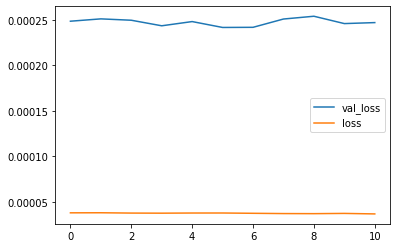

In [465]:
plt.plot(hist.history['val_loss'], label="val_loss")
plt.legend()
plt.plot(hist.history['loss'],label="loss")
plt.legend()


In [466]:
preds = np.squeeze(model.predict(map_valid, 1024, verbose=1))

83/83 [==============================] - 3s 30ms/step


In [467]:
preds_train = np.squeeze(model.predict(map_train, 1024, verbose=1))

743/743 [==============================] - 22s 30ms/step


In [468]:
def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)


In [469]:
print(log_max_inv(preds, max_log_y)[0])
print(log_max_inv(y_valid, max_log_y)[0])
print(math.sqrt(np.square(((log_max_inv(preds, max_log_y)[0] - log_max_inv(y_valid, max_log_y)[0])/log_max_inv(y_valid, max_log_y)[0]).mean())))

7186.6206
7955.999999999996
0.09670429795515921


In [470]:
preds_log_max_inv = log_max_inv(preds, max_log_y)
preds_log_max_inv_train = log_max_inv(preds_train, max_log_y)
#print(preds_log_max_inv)

In [471]:
y_valid_array =  log_max_inv(np.array(y_valid), max_log_y)
#print(y_valid_array)
y_train_array =  log_max_inv(np.array(y_train), max_log_y)

In [472]:
print("MRSE de valid: " + str(sqrt(mean(square((preds_log_max_inv - y_valid_array)/y_valid_array)))))
print("MRSE de train: " + str(sqrt(mean(square((preds_log_max_inv_train - y_train_array)/y_train_array)))))

MRSE de valid: 0.23183630245868458
MRSE de train: 0.05875014869501682


Se puede observar la presencia de overfitting lo cual podría mejorarse mediante técnicas de regularización y así obtener un mejor resultado del modelo.

In [473]:
pred_test = np.squeeze(model.predict(map_test, 1024, verbose=1))

41/41 [==============================] - 1s 30ms/step


In [474]:
predicciones = log_max_inv(pred_test, max_log_y)


In [475]:
test_final = pd.DataFrame(data=predicciones, columns=["Sales"],)
test_final.index.names = ["Id"]
test_final.index = test_final.index + 1
test_final

,Sales
Id,
1,5257.076660
2,5564.177734
3,8262.099609
4,9461.546875
5,4744.252930
...,...
41084,3201.286865
41085,9001.876953
41086,7839.365723


In [476]:
test_final.to_csv('submission.csv')